In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

import physicsnemo
from physicsnemo.models.fno.fno import FNO
from physicsnemo.metrics.general.mse import mse
from physicsnemo.datapipes.benchmarks.kelvin_helmholtz import KelvinHelmholtz2D

In [2]:
dataloader = KelvinHelmholtz2D(
    resolution = 256
)
dataloader = iter(dataloader)

In [3]:
batch = next(dataloader)

In [4]:
print(batch.keys())

dict_keys(['density', 'velocity', 'pressure'])


In [4]:
density = batch['density']
velocity = batch['velocity']
pressure = batch['pressure']
print(velocity.shape)
print(density.shape)
print(pressure.shape)

torch.Size([16, 8, 2, 256, 256])
torch.Size([16, 8, 1, 256, 256])
torch.Size([16, 8, 1, 256, 256])


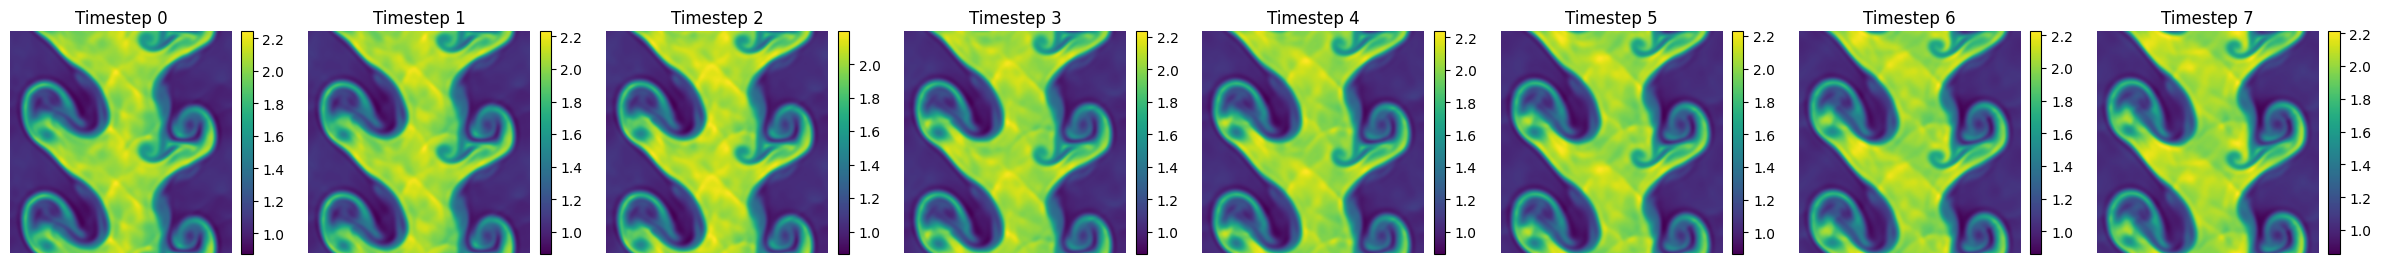

In [6]:
density_sample = density[0]
seq_length = density_sample.shape[0]
fig, axes = plt.subplots(1, seq_length, figsize=(3*seq_length, 3))
if seq_length == 1:
    axes = [axes]
for t in range(seq_length):
    density_t = density_sample[t].squeeze().cpu().numpy()
    im = axes[t].imshow(density_t, cmap='viridis')
    axes[t].set_title(f'Timestep {t}')
    axes[t].axis('off')
    plt.colorbar(im, ax=axes[t], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

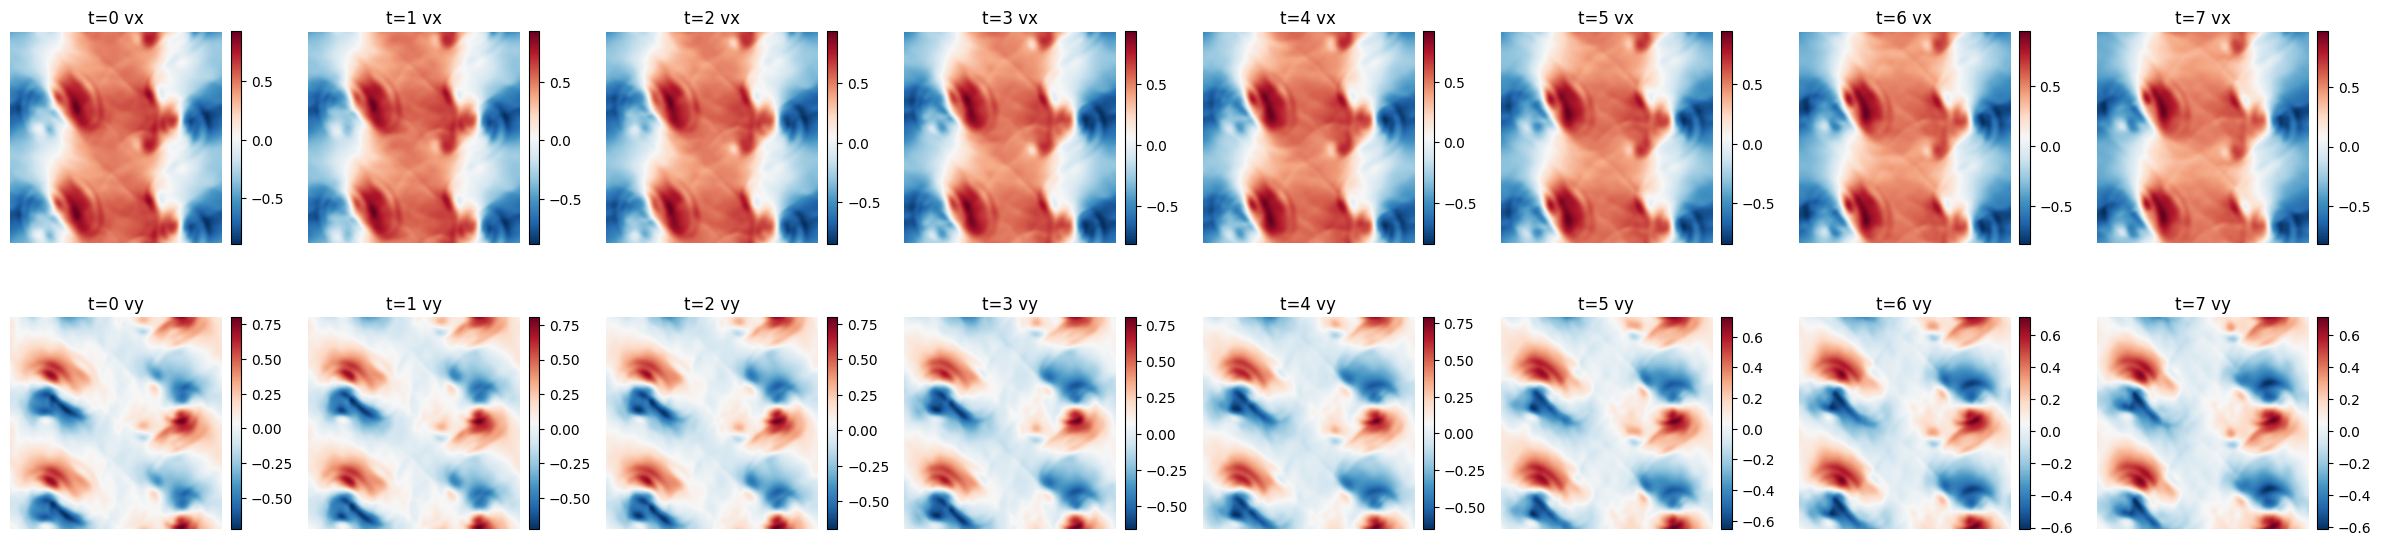

In [7]:
velocity_sample = velocity[0]
seq_length = velocity_sample.shape[0]
fig, axes = plt.subplots(2, seq_length, figsize=(3*seq_length, 6))
if seq_length == 1:
    axes = axes.reshape(2, 1)

for t in range(seq_length):
    velocity_t = velocity_sample[t].cpu().numpy()
    
    im0 = axes[0, t].imshow(velocity_t[0], cmap='RdBu_r')
    axes[0, t].set_title(f't={t} vx')
    axes[0, t].axis('off')
    plt.colorbar(im0, ax=axes[0, t], fraction=0.046, pad=0.04)
    
    im1 = axes[1, t].imshow(velocity_t[1], cmap='RdBu_r')
    axes[1, t].set_title(f't={t} vy')
    axes[1, t].axis('off')
    plt.colorbar(im1, ax=axes[1, t], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
model = FNO(
    in_channels=3,
    out_channels = 1,
    decoder_layers = 2,
    decoder_layer_size=32,
    dimension=2,
    latent_channels=32,
    num_fno_layers=10,
    num_fno_modes=12,
    padding=5,
).to('cuda') 

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [7]:
epoch = 300

In [8]:
#preprocess : want [batch, 3, h, w]
def preprocess(batch, t = 0):  
    """
    returns batched data for time step
    """
    density = batch['density']
    velocity = batch['velocity']
    pressure = batch['pressure']
    
    #Norm
    vx = velocity[:, t, 0:1]
    vy = velocity[:, t, 1:2]
    rho = density[:, t]
    p = pressure[:, t]
    
    # Subtract mean pressure (critical for pressure fields)
    p = p - p.mean(dim=(-2, -1), keepdim=True)
    
    # Normalize to roughly unit variance (compute these from data)
    vx = vx / 0.5  
    vy = vy / 0.5
    rho = (rho - 2.0) / 1.0  # center and scale density
    p = p / 0.5  # pressure scale
    
    x = torch.cat([vx, vy, rho], dim=1)
    return x, p

In [9]:
#Training
for i in range(epoch):
    optimizer.zero_grad()
    x, y = preprocess(next(dataloader))
    model_out = model(x)
    loss = mse(model_out, y)
    # loss = torch.mean(((model_out - y) ** 2).sum(dim=(-2,-1)) / (y ** 2).sum(dim=(-2,-1)))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    if i % 10 == 0:
        print(f"Iteration: {i}. Loss: {loss.detach().cpu().numpy()}")

Iteration: 0. Loss: 0.167547345161438
Iteration: 10. Loss: 0.16263312101364136
Iteration: 20. Loss: 0.1677234172821045
Iteration: 30. Loss: 0.16197112202644348
Iteration: 40. Loss: 0.10845614224672318
Iteration: 50. Loss: 0.0828591138124466
Iteration: 60. Loss: 0.08923856168985367
Iteration: 70. Loss: 0.05579505115747452
Iteration: 80. Loss: 0.06809338927268982
Iteration: 90. Loss: 0.061898425221443176
Iteration: 100. Loss: 0.06023268401622772
Iteration: 110. Loss: 0.0679410845041275
Iteration: 120. Loss: 0.054864320904016495
Iteration: 130. Loss: 0.05975440517067909
Iteration: 140. Loss: 0.05956510826945305
Iteration: 150. Loss: 0.06053831800818443
Iteration: 160. Loss: 0.053489118814468384
Iteration: 170. Loss: 0.05500582233071327
Iteration: 180. Loss: 0.05595151335000992
Iteration: 190. Loss: 0.060397107154130936
Iteration: 200. Loss: 0.0615236721932888
Iteration: 210. Loss: 0.06090138107538223
Iteration: 220. Loss: 0.05272248759865761
Iteration: 230. Loss: 0.05380109325051308
Itera

In [10]:
def visualize_comparison(x, y, pred, sample_idx=0, timestep=0):
    """
    Visualize input fields, ground truth pressure, and predicted pressure
    
    Args:
        x: Input tensor [batch, 3, H, W] - (vx, vy, density)
        y: Ground truth pressure [batch, 1, H, W]
        pred: Predicted pressure [batch, 1, H, W]
        sample_idx: Which sample from batch to visualize
        timestep: For labeling (which timestep this represents)
    """
    # Extract single sample and move to CPU
    vx = x[sample_idx, 0].detach().cpu().numpy()
    vy = x[sample_idx, 1].detach().cpu().numpy()
    rho = x[sample_idx, 2].detach().cpu().numpy()
    y_true = y[sample_idx, 0].detach().cpu().numpy()
    y_pred = pred[sample_idx, 0].detach().cpu().numpy()
    
    # Compute error
    error = np.abs(y_true - y_pred)
    
    # Create figure with 2 rows, 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Input fields
    im0 = axes[0, 0].imshow(vx, cmap='RdBu_r')
    axes[0, 0].set_title(f'Input: Velocity X (t={timestep})')
    axes[0, 0].axis('off')
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    im1 = axes[0, 1].imshow(vy, cmap='RdBu_r')
    axes[0, 1].set_title(f'Input: Velocity Y (t={timestep})')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    im2 = axes[0, 2].imshow(rho, cmap='viridis')
    axes[0, 2].set_title(f'Input: Density (t={timestep})')
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # Row 2: Ground truth, prediction, and error
    im3 = axes[1, 0].imshow(y_true, cmap='plasma')
    axes[1, 0].set_title('Ground Truth Pressure')
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    im4 = axes[1, 1].imshow(y_pred, cmap='plasma')
    axes[1, 1].set_title('Predicted Pressure')
    axes[1, 1].axis('off')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    im5 = axes[1, 2].imshow(error, cmap='hot')
    axes[1, 2].set_title(f'Absolute Error\nMSE: {np.mean(error**2):.6f}')
    axes[1, 2].axis('off')
    plt.colorbar(im5, ax=axes[1, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nPressure Statistics:")
    print(f"  Ground Truth - Min: {y_true.min():.4f}, Max: {y_true.max():.4f}, Mean: {y_true.mean():.4f}")
    print(f"  Predicted    - Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}, Mean: {y_pred.mean():.4f}")
    print(f"  Error        - Min: {error.min():.4f}, Max: {error.max():.4f}, Mean: {error.mean():.4f}")
    print(f"  MSE: {np.mean(error**2):.6f}")
    print(f"  MAE: {np.mean(error):.6f}")

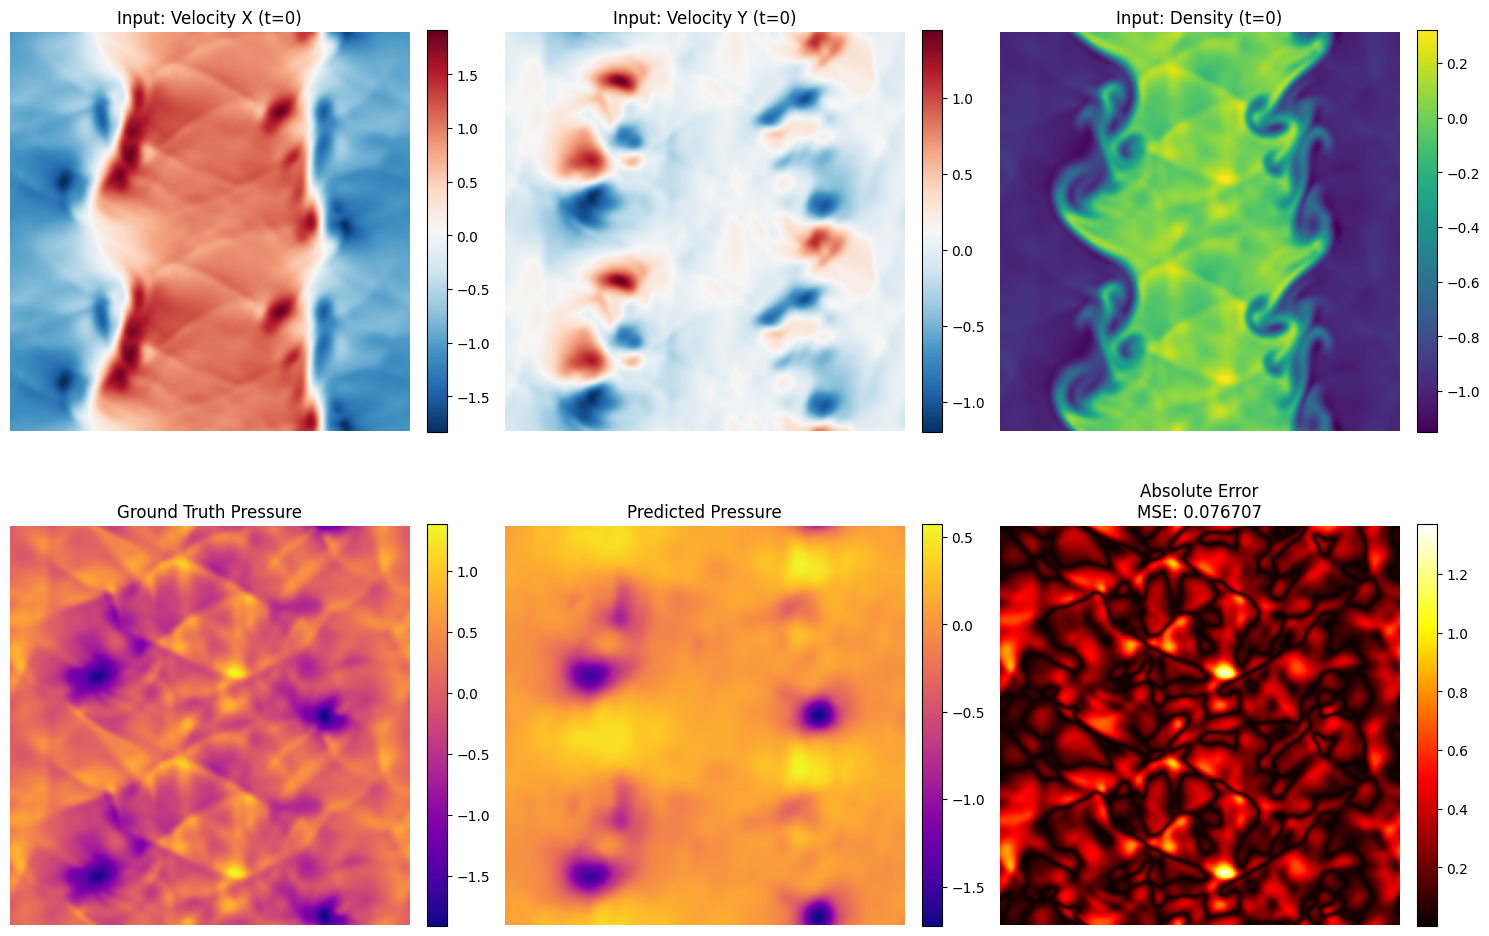


Pressure Statistics:
  Ground Truth - Min: -1.9139, Max: 1.3855, Mean: 0.0000
  Predicted    - Min: -1.7260, Max: 0.5733, Mean: 0.0030
  Error        - Min: 0.0000, Max: 1.3692, Mean: 0.2184
  MSE: 0.076707
  MAE: 0.218379


In [11]:
#visually validate

x, y = preprocess(next(dataloader))
with torch.no_grad():
    pred = model(x)

visualize_comparison(x, y, pred)